In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# draw the dark hole regions
from skimage.draw import draw

# PSD code
from scipy import signal
from scipy import interpolate
import h5py
import copy

#import poppy

# import personal code
import sys
sys.path.insert(0, '/home/jhen/XWCL/code/MagAOX/functions') # change this per computer
import psd_functions as psd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#print('This notebook is not stale yet!')

In [2]:
%%time
psd_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'surf_units': u.micron,
             'ring_width': 5,
             'diam_ca100': 50*u.mm,
             'kmid_ll': 0.1/u.mm,
             'khigh_ll': 1/u.mm} # useful for PSD

fileloc = 'zygo_data/flat_mirrors/fixed_fits/flat_2in_ca{0}_avg_dustmask_PSD.fits'.format(psd_parms['ca'])

avg_psd = psd.surfPSD(surf_name='fm2inch_avgPSD')
avg_psd.open_psd(psd_fileloc=fileloc, psd_type='cal')
avg_psd.calc_rms_set(kmid_ll=psd_parms['kmid_ll'], khigh_ll=psd_parms['khigh_ll'], pwr_opt=avg_psd.psd_cal)
avg_psd.calc_psd_radial(psd_parms['ring_width'])

CPU times: user 36.6 s, sys: 13.3 s, total: 50 s
Wall time: 48.9 s


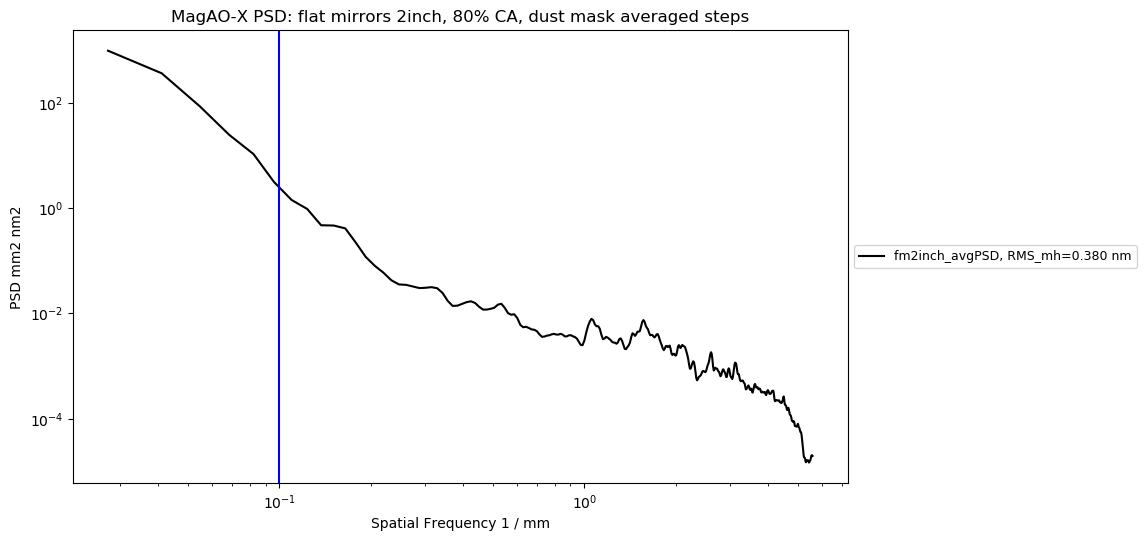

In [3]:
plt.figure(figsize=[10,6],dpi=100)
plt.loglog(avg_psd.k_radial.value, avg_psd.psd_radial_cal.value, 'k', label='{0}, RMS_mh={1:.3f}'.format(avg_psd.surf_name, avg_psd.rms_mh))
plt.xlabel('Spatial Frequency {0}'.format(avg_psd.k_radial.unit))
plt.ylabel('PSD {0}'.format(avg_psd.psd_radial_cal.unit))
plt.title('MagAO-X PSD: flat mirrors 2inch, {0}% CA, dust mask averaged steps'.format(psd_parms['ca']))
plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.axvline(x=0.1, color='b')

### Model the PSD
Base the model on the average PSD. Build a model through different spatial frequency bands.

In [42]:
# cut off spatial frequencies based on the limits
kmid_ll = 1/(10*u.mm)
kmid_ul = 1/(1*u.mm)
avg_rms_m = fm[n].calc_psd_rms(tgt_low=kmid_ll, tgt_high=kmid_ul,
                                        pwr_opt=cal_psd_avg)

# set the boundaries
k_range = avg_k_radial[avg_k_radial.value<kmid_ul.value]
k_range = k_range[k_range.value>kmid_ll.value]

# apply ranges to the PSD data
i_min = psd.k_locate(avg_k_radial, k_tgt=np.amin(k_range))[0]
i_max = psd.k_locate(avg_k_radial, k_tgt=np.amax(k_range))[0]
psd_range=avg_psd_radial[i_min:i_max+1] # you need to add the 1 to include the last number

# solve for the LSF values for alpha and beta
mid_a, mid_b = psd.solve_model_lsf(radial_psd=psd_range, radial_k=k_range)

# draw the model line
model_mid = psd.calc_model_simple(radial_k=avg_k_radial, alpha=mid_a, beta=mid_b)

# calculate PDR numbers
pdr_a = 2
pdr_b = psd.calc_beta(alpha=pdr_a, k_min=kmid_ll, k_max=kmid_ul, rms_surf=avg_rms_m)
model_mid_pdr = psd.calc_model_simple(radial_k=avg_k_radial, alpha=pdr_a, beta=pdr_b)

In [39]:
# check beta value
mid_b_calc = psd.calc_beta(alpha=mid_a, k_min=kmid_ll, k_max=kmid_ul, rms_surf=avg_rms_m)
(mid_b_calc, mid_b)

(<Quantity 0.00286165 nm2 / mm(0.4980261522838312)>,
 <Quantity 0.00211492 nm2 / mm(0.4980261522838312)>)

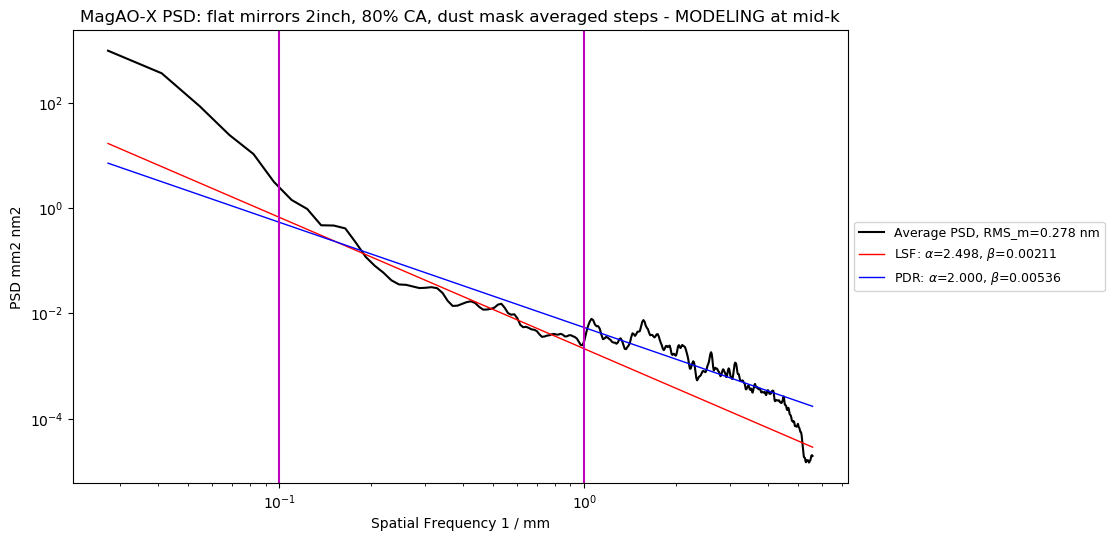

In [49]:
# check the plots
plt.figure(figsize=[10,6],dpi=100)
plt.loglog(avg_k_radial, avg_psd_radial, 'k', linewidth=1.5, label='Average PSD, RMS_m={0:.3f}'.format(avg_rms_m))
plt.loglog(avg_k_radial, model_mid, 'r', linewidth=1,
           label='LSF: {0}={1:.3f}, {2}={3:.5f}'.format(r'$\alpha$', mid_a, r'$\beta$', mid_b.value))
plt.loglog(avg_k_radial, model_mid_pdr, 'b', linewidth=1,
           label='PDR: {0}={1:.3f}, {2}={3:.5f}'.format(r'$\alpha$', pdr_a, r'$\beta$', pdr_b.value))
plt.xlabel('Spatial Frequency {0}'.format(fm[0].k_radial.unit))
plt.ylabel('PSD {0}'.format(fm[0].psd_radial_cal.unit))
plt.title('MagAO-X PSD: flat mirrors 2inch, {0}% CA, dust mask averaged steps - MODELING at mid-k'.format(opt_parms['ca']))
plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.axvline(x=0.1, color='m')
plt.axvline(x=1, color='m')

In [9]:
# solve for the LSF values of alpha and beta
# cut off the high frequency slump at the end
k_range = oap[0].k_radial[np.log10(oap[0].k_radial.value)<0.95] # in log scale, this is the cutoff
avg_cpsd = avg_psd_cal[0:len(k_range)]
la, lb = psd.solve_model_lsf(avg_cpsd, k_range)

# calculate average surface roughness rms
sr_rms = [0.51, 0.54, 1.00, 0.59, 0.5, 0.41, 0.44, 0.43] * u.nm
avg_sr_rms = np.mean(sr_rms)
bsr = psd.calc_bsr(rms_sr = avg_sr_rms, k_min = oap[0].k_min, k_max = oap[0].k_max)
bsr
# all OAPs sampled same, so have same k_min and k_max

/home/jhen/XWCL/code/MagAOX/functions/psd_functions.py:237: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m,c = np.linalg.lstsq(A, y)[0] # y = mx + c linear equation


<Quantity 0.00105786 mm2 nm2>

In [10]:
# Expand spatial freq range to see where the model takes us with the data

# concatenate array for front
last = np.min(k_range) - oap[0].delta_k # initialize
front_fill = []
while last.value>0:
    front_fill.append(last.value)
    last = last - oap[0].delta_k
front_k = np.hstack((np.asarray(front_fill[::-1]), np.asarray(oap[0].k_radial.value)))

# concatenate array for end
nex_pts = 800
dkr = (oap[0].k_radial[1] - oap[0].k_radial[0]).value
dkr_mult = 3
rear_fill = [(np.amax(oap[0].k_radial.value) + (dkr*dkr_mult))]
for i in range(1, nex_pts): rear_fill.append(rear_fill[i-1] + (dkr*dkr_mult))
new_k = np.hstack((front_k, np.asarray(rear_fill)))*oap[0].k_radial.unit
    
#verify it all went together, should end up as 0
# np.shape(new_k)[0] - len(front_fill) - len(rear_fill) - len(oap[0].k_radial)
new_k

<Quantity [4.67966642e-03, 9.35933285e-03, 1.40389993e-02, ...,
           6.55668063e+01, 6.56370013e+01, 6.57071963e+01] 1 / mm>

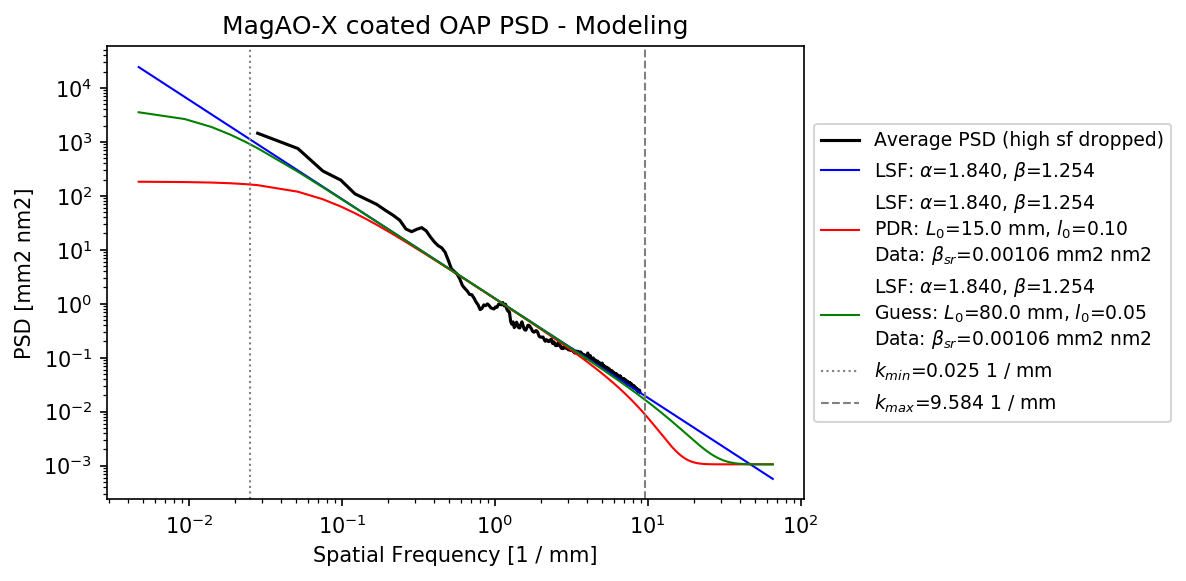

In [11]:
# extend k-range for LSF
p_lsf_ext = psd.calc_model_simple(new_k, la, lb)

# PDR L's
lo = 0.1
L0 = 15*u.mm
p_full = psd.calc_model_full(new_k, la, lb, L0, lo, bsr)

# guessing the L's
g_lo = 0.05
g_L0 = 80*u.mm
p_full_guess = psd.calc_model_full(new_k, la, lb, g_L0, g_lo, bsr)

# check the plots
plt.figure(dpi=150)
plt.loglog(k_range, avg_cpsd, 'k', linewidth=1.5, label='Average PSD (high sf dropped)')
plt.loglog(new_k, p_lsf_ext, 'b', linewidth=1,
           label='LSF: {0}={1:.3f}, {2}={3:.3f}'.format(r'$\alpha$', la, r'$\beta$', lb.value))
plt.loglog(new_k, p_full, 'r', linewidth=1,
           label='LSF: {0}={1:.3f}, {2}={3:.3f}\nPDR: {4}={5}, {6}={7:.2f}\nData: {8}={9:.5f}'.format(r'$\alpha$', la, 
                                                                         r'$\beta$', lb.value, 
                                                                         r'$L_{0}$',L0, 
                                                                         r'$l_{0}$', lo,
                                                                         r'$\beta_{sr}$', bsr))
plt.loglog(new_k, p_full_guess, 'g', linewidth=1,
           label='LSF: {0}={1:.3f}, {2}={3:.3f}\nGuess: {4}={5}, {6}={7:.2f}\nData: {8}={9:.5f}'.format(r'$\alpha$', la, 
                                                                         r'$\beta$', lb.value, 
                                                                         r'$L_{0}$', g_L0, 
                                                                         r'$l_{0}$', g_lo,
                                                                         r'$\beta_{sr}$', bsr))
plt.axvline(x=oap[0].k_min.value, color='grey', ls=':', label='{0}={1:.3f}'.format(r'$k_{min}$', oap[0].k_min), linewidth=1)
plt.axvline(x=oap[0].k_max.value, color='grey', ls='--', label='{0}={1:.3f}'.format(r'$k_{max}$', oap[0].k_max), linewidth=1)
plt.xlabel('Spatial Frequency [{0}]'.format(oap[0].k_radial.unit))
plt.ylabel('PSD [{0}]'.format(avg_psd_cal.unit))
plt.title('MagAO-X coated OAP PSD - Modeling')
plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))

In [16]:
bsr

<Quantity 0.00105786 mm2 nm2>

In [21]:
from scipy.optimize import curve_fit
def model_lo_L0(k, alpha, beta, lo, L0, bsr):
    #return ((beta*np.exp(-(k*lo)**2)) / ( ((L0**-2) + (k**2))**(alpha/2) )) + bsr
    return (beta*np.exp(-(k*lo)**2)/(k**alpha)) + bsr

def model_lo(k, lo):
    # hard-coded from past calculations
    alpha = 1.8395337855459057 # linear LSF
    beta = 1.2542724 # linear LSF
    bsr = 0.0010578594 # calculated from data
    return (beta*np.exp(-(k*lo)**2)/(k**alpha)) + bsr

popt, pcov = curve_fit(model_lo, k_range.value, avg_cpsd.value)
popt

array([-5.45857637e-06])

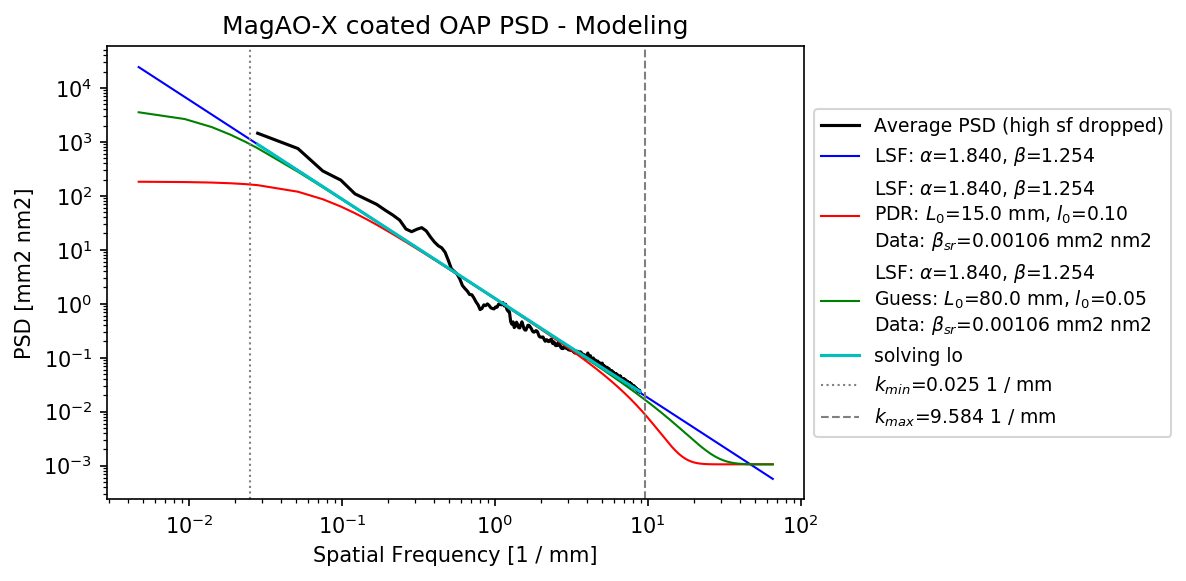

In [22]:
psd_lo = model_lo(k=k_range.value,lo=popt[0])
# check the plots
plt.figure(dpi=150)
plt.loglog(k_range, avg_cpsd, 'k', linewidth=1.5, label='Average PSD (high sf dropped)')
plt.loglog(new_k, p_lsf_ext, 'b', linewidth=1,
           label='LSF: {0}={1:.3f}, {2}={3:.3f}'.format(r'$\alpha$', la, r'$\beta$', lb.value))
plt.loglog(new_k, p_full, 'r', linewidth=1,
           label='LSF: {0}={1:.3f}, {2}={3:.3f}\nPDR: {4}={5}, {6}={7:.2f}\nData: {8}={9:.5f}'.format(r'$\alpha$', la, 
                                                                         r'$\beta$', lb.value, 
                                                                         r'$L_{0}$',L0, 
                                                                         r'$l_{0}$', lo,
                                                                         r'$\beta_{sr}$', bsr))
plt.loglog(new_k, p_full_guess, 'g', linewidth=1,
           label='LSF: {0}={1:.3f}, {2}={3:.3f}\nGuess: {4}={5}, {6}={7:.2f}\nData: {8}={9:.5f}'.format(r'$\alpha$', la, 
                                                                         r'$\beta$', lb.value, 
                                                                         r'$L_{0}$', g_L0, 
                                                                         r'$l_{0}$', g_lo,
                                                                         r'$\beta_{sr}$', bsr))
plt.loglog(k_range, psd_lo, 'c', label='solving lo')
plt.axvline(x=oap[0].k_min.value, color='grey', ls=':', label='{0}={1:.3f}'.format(r'$k_{min}$', oap[0].k_min), linewidth=1)
plt.axvline(x=oap[0].k_max.value, color='grey', ls='--', label='{0}={1:.3f}'.format(r'$k_{max}$', oap[0].k_max), linewidth=1)
plt.xlabel('Spatial Frequency [{0}]'.format(oap[0].k_radial.unit))
plt.ylabel('PSD [{0}]'.format(avg_psd_cal.unit))
plt.title('MagAO-X coated OAP PSD - Modeling')
plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))